In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import entropy as scipy_entropy

from sklearn.ensemble import RandomTreesEmbedding
from sklearn.tree import DecisionTreeClassifier
import sys
sys.path.append("../src/ppscore")
from preprocessing import RobustKBinsDiscretizer

# Data

In [3]:
n = 10_000
# X = np.random.randn(n)
# Y = X**2 + np.random.randn(n)
# Z = X*Y + 10*np.random.binomial(1,0.3, n)

X = np.random.uniform(-3,3,n)
Y = np.random.lognormal(0,1.3,n)
cat= np.random.binomial(1,0.3, n )
W = np.random.uniform(-3,3,n)
Z = X*Y + Y*10*cat + 3*np.random.randn(n)# + 10*np.random.binomial(1,0.3, n)


In [4]:
XY = np.array([X,Y]).T
XZ = np.array([X,Z]).T
YZ = np.array([Y,Z]).T
XYZ = np.array([X,Y,Z]).T

XYZWcat = np.array([X,Y,Z,W,cat]).T

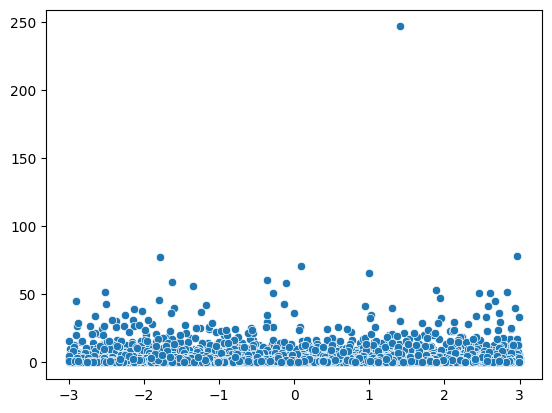

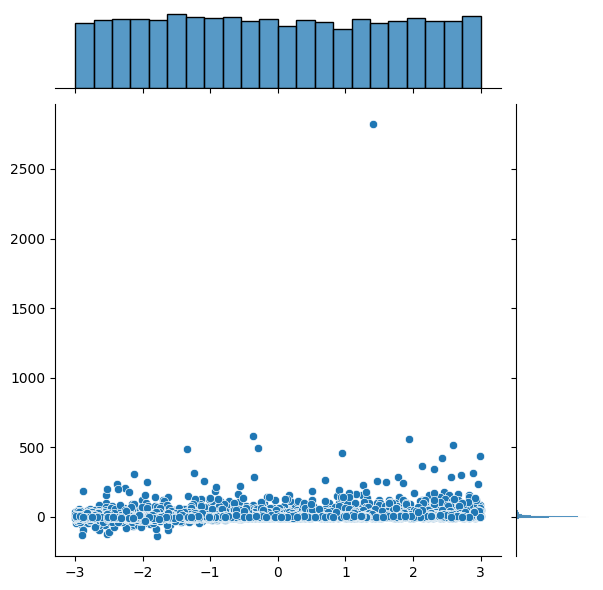

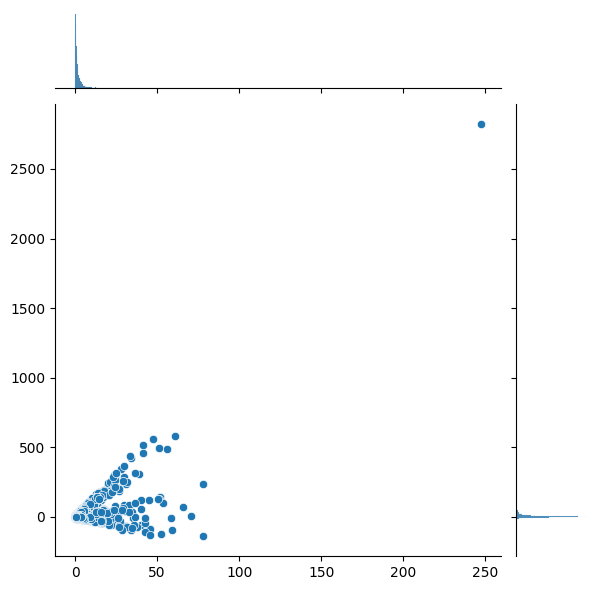

In [5]:
sns.scatterplot(x=X,y=Y)
sns.jointplot(x=X,y=Z)
sns.jointplot(x=Y,y=Z)


In [6]:
from scipy import stats

In [7]:
# n = 100_000
# X = np.random.randn(n)
# Y = np.random.randn(n)
# cat = np.random.binomial(1, 0.3, size = n)
# Z = X + Y#+ 10*np.random.binomial(1,0.3, n)

In [8]:
XY = np.array([X,Y]).T
XZ = np.array([X,Z]).T
YZ = np.array([Y,Z]).T
Ycat = np.array([Y,cat]).T
XYcat = np.array([X,Y,cat]).T
XYZ = np.array([X,Y,Z]).T

# Test

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer
from sklearn.base import BaseEstimator, clone
from copy import deepcopy

class _MutualInformationForest(BaseEstimator):
    
    """A decision tree classifier where the target is discretized. usefull to transform regression into classification.
    One can choose to discretize X as well or not. Discretization is performed using RobustKBinsDiscretizer. 
    This estimator is robust to np.inf, -np.inf and np.nans if handle_nan is set to True. if one chooses to discretize X, it is also robust in the same cases.
    Also, this implementation exposesget_leaf_entropies and get_information_gain as usefull methods for mutual information estimation.
        
    
    """
    
    
    def __init__(        
        self,
        forest_estimator,
        prefit_estimator = False,
        *,       
        #quantization params
        n_bins_X=None,        
        n_bins_y=10,        
        strategy_X='kmeans',
        strategy_y='kmeans',
        handle_nan_X = 'handle', #error, handle, ignore        
        handle_nan_y = 'handle', #error, handle, ignore        
    ):
        
        
        self.forest_estimator = forest_estimator
        self.prefit_estimator = prefit_estimator
        self.n_bins_X = n_bins_X
        self.n_bins_y = n_bins_y
        self.strategy_X = strategy_X
        self.strategy_y = strategy_y
        self.handle_nan_X = handle_nan_X
        self.handle_nan_y = handle_nan_y
        return
    
    def _ensure_2d(self, arr):
        if arr.ndim == 1:
            arr = arr.reshape(-1,1)
        return arr
    
    def _fit_preprocess_data(self, X, y = None):        
        
        X = self._ensure_2d(X)
        max_X = X.max()
        min_X = X.min()
        
        if not self.n_bins_X is None:
            nanimputer = FunctionTransformer()
            infimputer = FunctionTransformer()
            neginfimputer = FunctionTransformer()
            x_quant = RobustKBinsDiscretizer(self.n_bins_X, encode = "ordinal", handle_nan = self.handle_nan_X, strategy=self.strategy_X)
        else:
            if self.handle_nan_X == "handle":
                nanimputer = FunctionTransformer(lambda x: np.where(x!=x,min_X-2, x))                     
                infimputer = FunctionTransformer(lambda x: np.where(x==np.inf,max_X+1, x))
                neginfimputer = FunctionTransformer(lambda x: np.where(x==-np.inf,min_X-1, x))             
                x_quant = FunctionTransformer()
            else:
                nanimputer = FunctionTransformer()
                infimputer = FunctionTransformer()
                neginfimputer = FunctionTransformer()
                x_quant = FunctionTransformer()
                
                
        
        if not y is None:
            y = self._ensure_2d(y)
            
            max_y = y.max()
            min_y = y.min()
            
            y_infimputer = FunctionTransformer(lambda x: np.where(x==np.inf,max_y+1, x))
            y_neginfimputer = FunctionTransformer(lambda x: np.where(x==-np.inf,min_y-1, x))             
            
            y_quant = RobustKBinsDiscretizer(self.n_bins_y, encode = "ordinal", handle_nan = self.handle_nan_y, strategy=self.strategy_y)
            self.y_preprocessor = make_pipeline(y_infimputer, y_neginfimputer, y_quant).fit(y)
        
        self.X_preprocessor = make_pipeline(infimputer, neginfimputer, nanimputer, x_quant).fit(X)
    
    def _preprocess_data(self, X, y = None):
        X = self._ensure_2d(X)
        X = self.X_preprocessor.transform(X)
        if not y is None:
            y = self._ensure_2d(y)
            y = self.y_preprocessor.transform(y)
        else:
            y = None
        
        return X, y
    
    def fit(self, X, y = None, sample_weight = None):
        self._fit_preprocess_data(X,y)
        X,y = self._preprocess_data(X,y)
        if not self.prefit_estimator:
            self.forest_estimator_ = clone(self.forest_estimator).fit(X, y = y, sample_weight = sample_weight)
        else:
            self.forest_estimator_ = deepcopy(self.forest_estimator)
        return self
    
    def predict(self, X, **kwargs):
        X,y = self._preprocess_data(X,None)
        return self.forest_estimator_().predict(X, **kwargs)
    
    def apply(self, X, **kwargs):
        X,y = self._preprocess_data(X,None)
        return self.forest_estimator_.apply(X, **kwargs)
    
    def predict_proba(self, X, **kwargs):
        X,y = self._preprocess_data(X,None)
        return self.forest_estimator_.predict_proba(X, **kwargs)
    
    def predict_log_proba(self, X, **kwargs):
        X,y = self._preprocess_data(X,None)
        return self.forest_estimator_.predict_log_proba(X, **kwargs)
    
    def cost_complexity_pruning_path(self, X, y = None, **kawrgs):
        X,y = self._preprocess_data(X,y)
        return self.forest_estimator_.cost_complexity_pruning_path(X, y, **kwargs)

    def decision_path(self, X):
        X,y = self._preprocess_data(X,None)
        return self.forest_estimator_.decision_path(X)
    
    def get_leaf_entropies(self, X, y, sample_weight = None):
        
        X,y = self._preprocess_data(X,y)
        leafs = self.apply(X)
        #flatten avoiding colisions
        n_trees = leafs.shape[1]        
        leafs = leafs + (leafs.max(0)+1).cumsum()
        leafs = leafs.T.flatten()
        y=np.hstack(n_trees*[y.flatten()])
        
        if sample_weight is None:
            total_sample_size = len(y)
            a = np.array([leafs,y]).T
            a = a[a[:, 0].argsort()]
            entropies = np.array([(len(i)/total_sample_size)*entropy(i) for i in np.split(a[:, 1], np.unique(a[:, 0], return_index=True)[1][1:])])
        else:
            total_sample_size = np.sum(sample_weight)
            a = np.array([leafs,y, sample_weight]).T
            a = a[a[:, 0].argsort()]
            groups = np.split(a[:, 1:], np.unique(a[:, 0], return_index=True)[1][1:])
            entropies = np.array([(len(i)/total_sample_size)*entropy(i[:,0], i[:,1]) for i in groups])
        return entropies
    
    def get_information_gain(self, X, y, sample_weight = None):
        
        y = np.array(y)
        
        leaf_entropies_avg = np.sum(self.get_leaf_entropies(X, y, sample_weight))                        
        shuffled_idx = np.random.choice(np.arange(len(y.flatten())), len(y.flatten()), replace = False)
        
        y_shuffled = y[shuffled_idx]
        if not sample_weight is None:
            sample_weight = sample_weight[shuffled_idx]
            
        sample_entropy = np.sum(self.get_leaf_entropies(X, y_shuffled, sample_weight))
        information_gain = (sample_entropy - leaf_entropies_avg)/sample_entropy
        return max(0, information_gain)
    
    def score(self, X, y, sample_weight = None):
        return self.get_information_gain(X, y, sample_weight)
        
def entropy(leaf_targets, sample_weight = None):
    if sample_weight is None:
        _, p = np.unique(leaf_targets, return_counts=True)
        p = p/p.sum()

    else:        
        p = np.zeros((leaf_targets.size, int(leaf_targets.max() + 1)), dtype = float)
        p[np.arange(leaf_targets.size), leaf_targets.astype(int)] = 1
        p = p*(sample_weight.reshape(-1,1))
        p = p.sum(0)
        p = p[p>0]
        p = p/p.sum()        
    return np.sum(-p*np.log(p))        

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer


class DiscretizedTree(DecisionTreeClassifier):
    
    """A decision tree classifier where the target is discretized. usefull to transform regression into classification.
    One can choose to discretize X as well or not. Discretization is performed using RobustKBinsDiscretizer. 
    This estimator is robust to np.inf, -np.inf and np.nans if handle_nan is set to True. if one chooses to discretize X, it is also robust in the same cases.
    Also, this implementation exposesget_leaf_entropies and get_information_gain as usefull methods for mutual information estimation.
    
    Read more in the :ref:`User Guide <tree>`.
    Parameters
    ----------
    criterion : {"gini", "entropy", "log_loss"}, default="gini"
        The function to measure the quality of a split. Supported criteria are
        "gini" for the Gini impurity and "log_loss" and "entropy" both for the
        Shannon information gain, see :ref:`tree_mathematical_formulation`.
    splitter : {"best", "random"}, default="best"
        The strategy used to choose the split at each node. Supported
        strategies are "best" to choose the best split and "random" to choose
        the best random split.
    max_depth : int, default=None
        The maximum depth of the tree. If None, then nodes are expanded until
        all leaves are pure or until all leaves contain less than
        min_samples_split samples.
    min_samples_split : int or float, default=2
        The minimum number of samples required to split an internal node:
        - If int, then consider `min_samples_split` as the minimum number.
        - If float, then `min_samples_split` is a fraction and
          `ceil(min_samples_split * n_samples)` are the minimum
          number of samples for each split.
        .. versionchanged:: 0.18
           Added float values for fractions.
    min_samples_leaf : int or float, default=1
        The minimum number of samples required to be at a leaf node.
        A split point at any depth will only be considered if it leaves at
        least ``min_samples_leaf`` training samples in each of the left and
        right branches.  This may have the effect of smoothing the model,
        especially in regression.
        - If int, then consider `min_samples_leaf` as the minimum number.
        - If float, then `min_samples_leaf` is a fraction and
          `ceil(min_samples_leaf * n_samples)` are the minimum
          number of samples for each node.
        .. versionchanged:: 0.18
           Added float values for fractions.
    min_weight_fraction_leaf : float, default=0.0
        The minimum weighted fraction of the sum total of weights (of all
        the input samples) required to be at a leaf node. Samples have
        equal weight when sample_weight is not provided.
    max_features : int, float or {"auto", "sqrt", "log2"}, default=None
        The number of features to consider when looking for the best split:
            - If int, then consider `max_features` features at each split.
            - If float, then `max_features` is a fraction and
              `max(1, int(max_features * n_features_in_))` features are considered at
              each split.
            - If "auto", then `max_features=sqrt(n_features)`.
            - If "sqrt", then `max_features=sqrt(n_features)`.
            - If "log2", then `max_features=log2(n_features)`.
            - If None, then `max_features=n_features`.
            .. deprecated:: 1.1
                The `"auto"` option was deprecated in 1.1 and will be removed
                in 1.3.
        Note: the search for a split does not stop until at least one
        valid partition of the node samples is found, even if it requires to
        effectively inspect more than ``max_features`` features.
    random_state : int, RandomState instance or None, default=None
        Controls the randomness of the estimator. The features are always
        randomly permuted at each split, even if ``splitter`` is set to
        ``"best"``. When ``max_features < n_features``, the algorithm will
        select ``max_features`` at random at each split before finding the best
        split among them. But the best found split may vary across different
        runs, even if ``max_features=n_features``. That is the case, if the
        improvement of the criterion is identical for several splits and one
        split has to be selected at random. To obtain a deterministic behaviour
        during fitting, ``random_state`` has to be fixed to an integer.
        See :term:`Glossary <random_state>` for details.
    max_leaf_nodes : int, default=None
        Grow a tree with ``max_leaf_nodes`` in best-first fashion.
        Best nodes are defined as relative reduction in impurity.
        If None then unlimited number of leaf nodes.
    min_impurity_decrease : float, default=0.0
        A node will be split if this split induces a decrease of the impurity
        greater than or equal to this value.
        The weighted impurity decrease equation is the following::
            N_t / N * (impurity - N_t_R / N_t * right_impurity
                                - N_t_L / N_t * left_impurity)
        where ``N`` is the total number of samples, ``N_t`` is the number of
        samples at the current node, ``N_t_L`` is the number of samples in the
        left child, and ``N_t_R`` is the number of samples in the right child.
        ``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,
        if ``sample_weight`` is passed.
        .. versionadded:: 0.19
    class_weight : dict, list of dict or "balanced", default=None
        Weights associated with classes in the form ``{class_label: weight}``.
        If None, all classes are supposed to have weight one. For
        multi-output problems, a list of dicts can be provided in the same
        order as the columns of y.
        Note that for multioutput (including multilabel) weights should be
        defined for each class of every column in its own dict. For example,
        for four-class multilabel classification weights should be
        [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 1}, {0: 1, 1: 1}] instead of
        [{1:1}, {2:5}, {3:1}, {4:1}].
        The "balanced" mode uses the values of y to automatically adjust
        weights inversely proportional to class frequencies in the input data
        as ``n_samples / (n_classes * np.bincount(y))``
        For multi-output, the weights of each column of y will be multiplied.
        Note that these weights will be multiplied with sample_weight (passed
        through the fit method) if sample_weight is specified.
    ccp_alpha : non-negative float, default=0.0
        Complexity parameter used for Minimal Cost-Complexity Pruning. The
        subtree with the largest cost complexity that is smaller than
        ``ccp_alpha`` will be chosen. By default, no pruning is performed. See
        :ref:`minimal_cost_complexity_pruning` for details.
        .. versionadded:: 0.22
    Attributes
    ----------
    classes_ : ndarray of shape (n_classes,) or list of ndarray
        The classes labels (single output problem),
        or a list of arrays of class labels (multi-output problem).
    feature_importances_ : ndarray of shape (n_features,)
        The impurity-based feature importances.
        The higher, the more important the feature.
        The importance of a feature is computed as the (normalized)
        total reduction of the criterion brought by that feature.  It is also
        known as the Gini importance [4]_.
        Warning: impurity-based feature importances can be misleading for
        high cardinality features (many unique values). See
        :func:`sklearn.inspection.permutation_importance` as an alternative.
    max_features_ : int
        The inferred value of max_features.
    n_classes_ : int or list of int
        The number of classes (for single output problems),
        or a list containing the number of classes for each
        output (for multi-output problems).
    n_features_in_ : int
        Number of features seen during :term:`fit`.
        .. versionadded:: 0.24
    feature_names_in_ : ndarray of shape (`n_features_in_`,)
        Names of features seen during :term:`fit`. Defined only when `X`
        has feature names that are all strings.
        .. versionadded:: 1.0
    n_outputs_ : int
        The number of outputs when ``fit`` is performed.
    tree_ : Tree instance
        The underlying Tree object. Please refer to
        ``help(sklearn.tree._tree.Tree)`` for attributes of Tree object and
        :ref:`sphx_glr_auto_examples_tree_plot_unveil_tree_structure.py`
        for basic usage of these attributes.
    See Also
    --------
    DecisionTreeRegressor : A decision tree regressor.
    Notes
    -----
    The default values for the parameters controlling the size of the trees
    (e.g. ``max_depth``, ``min_samples_leaf``, etc.) lead to fully grown and
    unpruned trees which can potentially be very large on some data sets. To
    reduce memory consumption, the complexity and size of the trees should be
    controlled by setting those parameter values.
    The :meth:`predict` method operates using the :func:`numpy.argmax`
    function on the outputs of :meth:`predict_proba`. This means that in
    case the highest predicted probabilities are tied, the classifier will
    predict the tied class with the lowest index in :term:`classes_`.
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Decision_tree_learning
    .. [2] L. Breiman, J. Friedman, R. Olshen, and C. Stone, "Classification
           and Regression Trees", Wadsworth, Belmont, CA, 1984.
    .. [3] T. Hastie, R. Tibshirani and J. Friedman. "Elements of Statistical
           Learning", Springer, 2009.
    .. [4] L. Breiman, and A. Cutler, "Random Forests",
           https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> from sklearn.tree import DecisionTreeClassifier
    >>> clf = DecisionTreeClassifier(random_state=0)
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)
    ...                             # doctest: +SKIP
    ...
    array([ 1.     ,  0.93...,  0.86...,  0.93...,  0.93...,
            0.93...,  0.93...,  1.     ,  0.93...,  1.      ])
    """
    
    
    def __init__(        
        self,
        *,        
        #tree params
        criterion="gini",
        splitter="best",
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features=None,
        random_state=None,
        max_leaf_nodes=100,
        min_impurity_decrease=0.0,
        class_weight=None,
        ccp_alpha=0.0,
        #quantization params
        n_bins_X=None,        
        n_bins_y=10,        
        strategy_X='kmeans',
        strategy_y='kmeans',
        handle_nan_X = 'handle', #error, handle, ignore        
        handle_nan_y = 'handle', #error, handle, ignore        
    ):
        
        
        self.n_bins_X = n_bins_X
        self.n_bins_y = n_bins_y
        self.strategy_X = strategy_X
        self.strategy_y = strategy_y
        self.handle_nan_X = handle_nan_X
        self.handle_nan_y = handle_nan_y
        
        super().__init__(
            criterion=criterion,
            splitter=splitter,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf,
            max_features=max_features,
            max_leaf_nodes=max_leaf_nodes,
            class_weight=class_weight,
            random_state=random_state,
            min_impurity_decrease=min_impurity_decrease,
            ccp_alpha=ccp_alpha,
        )
        return
    
    def _ensure_2d(self, arr):
        if arr.ndim == 1:
            arr = arr.reshape(-1,1)
        return arr
    
    def _fit_preprocess_data(self, X, y = None):        
        
        X = self._ensure_2d(X)
        max_X = X.max()
        min_X = X.min()
        
        if not self.n_bins_X is None:
            nanimputer = FunctionTransformer()
            infimputer = FunctionTransformer()
            neginfimputer = FunctionTransformer()
            x_quant = RobustKBinsDiscretizer(self.n_bins_X, encode = "ordinal", handle_nan = self.handle_nan_X, strategy=self.strategy_X)
        else:
            if self.handle_nan_X == "handle":
                nanimputer = FunctionTransformer(lambda x: np.where(x!=x,min_X-2, x))                     
                infimputer = FunctionTransformer(lambda x: np.where(x==np.inf,max_X+1, x))
                neginfimputer = FunctionTransformer(lambda x: np.where(x==-np.inf,min_X-1, x))             
                x_quant = FunctionTransformer()
            else:
                nanimputer = FunctionTransformer()
                infimputer = FunctionTransformer()
                neginfimputer = FunctionTransformer()
                x_quant = FunctionTransformer()
                
                
        
        if not y is None:
            y = self._ensure_2d(y)
            
            max_y = y.max()
            min_y = y.min()
            
            y_infimputer = FunctionTransformer(lambda x: np.where(x==np.inf,max_y+1, x))
            y_neginfimputer = FunctionTransformer(lambda x: np.where(x==-np.inf,min_y-1, x))             
            
            y_quant = RobustKBinsDiscretizer(self.n_bins_y, encode = "ordinal", handle_nan = self.handle_nan_y, strategy=self.strategy_y)
            self.y_preprocessor = make_pipeline(y_infimputer, y_neginfimputer, y_quant).fit(y)
        
        self.X_preprocessor = make_pipeline(infimputer, neginfimputer, nanimputer, x_quant).fit(X)
    
    def _preprocess_data(self, X, y = None):
        X = self._ensure_2d(X)
        X = self.X_preprocessor.transform(X)
        if not y is None:
            y = self._ensure_2d(y)
            y = self.y_preprocessor.transform(y)
        else:
            y = None
        
        return X, y
    
    def fit(self, X, y = None, sample_weight = None):
        self._fit_preprocess_data(X,y)
        X,y = self._preprocess_data(X,y)
        super().fit(X, y = y, sample_weight = sample_weight)
        return self
    
    def predict(self, X, **kwargs):
        X,y = self._preprocess_data(X,None)
        return super().predict(X, **kwargs)
    
    def apply(self, X, **kwargs):
        X,y = self._preprocess_data(X,None)
        return super().apply(X, **kwargs)
    
    def predict_proba(self, X, **kwargs):
        X,y = self._preprocess_data(X,None)
        return super().predict_proba(X, **kwargs)
    
    def predict_log_proba(self, X, **kwargs):
        X,y = self._preprocess_data(X,None)
        return super().predict_log_proba(X, **kwargs)
    
    def cost_complexity_pruning_path(self, X, y = None, **kawrgs):
        X,y = self._preprocess_data(X,y)
        return super().cost_complexity_pruning_path(X, y, **kwargs)

    def decision_path(self, X):
        X,y = self._preprocess_data(X,None)
        return super().decision_path(X)
    
    def get_leaf_entropies(self, X, y, sample_weight = None):
        
        X,y = self._preprocess_data(X,y)
        leafs = self.apply(X)
        
        y=y.flatten()
        if sample_weight is None:
            total_sample_size = len(y)
            a = np.array([leafs,y]).T
            a = a[a[:, 0].argsort()]
            entropies = np.array([(len(i)/total_sample_size)*entropy(i) for i in np.split(a[:, 1], np.unique(a[:, 0], return_index=True)[1][1:])])
        else:
            total_sample_size = np.sum(sample_weight)
            a = np.array([leafs,y, sample_weight]).T
            a = a[a[:, 0].argsort()]
            groups = np.split(a[:, 1:], np.unique(a[:, 0], return_index=True)[1][1:])
            entropies = np.array([(len(i)/total_sample_size)*entropy(i[:,0], i[:,1]) for i in groups])
        return entropies
    
    def get_information_gain(self, X, y, sample_weight = None):
        
        y = np.array(y)        
        leaf_entropies_avg = np.sum(self.get_leaf_entropies(X, y, sample_weight))                
        shuffled_idx = np.random.choice(np.arange(len(y.flatten())), len(y.flatten()), replace = False)
        
        y_shuffled = y[shuffled_idx]
        if not sample_weight is None:
            sample_weight = sample_weight[shuffled_idx]
            
        sample_entropy = np.sum(self.get_leaf_entropies(X, y_shuffled, sample_weight))
        information_gain = (sample_entropy - leaf_entropies_avg)/sample_entropy
        return max(0, information_gain)
    
    def score(self, X, y, sample_weight = None):
        return self.get_information_gain(X, y, sample_weight)
        
def entropy(leaf_targets, sample_weight = None):
    if sample_weight is None:
        _, p = np.unique(leaf_targets, return_counts=True)
        p = p/p.sum()

    else:        
        p = np.zeros((leaf_targets.size, int(leaf_targets.max() + 1)), dtype = float)
        p[np.arange(leaf_targets.size), leaf_targets.astype(int)] = 1
        p = p*(sample_weight.reshape(-1,1))
        p = p.sum(0)
        p = p[p>0]
        p = p/p.sum()        
    return np.sum(-p*np.log(p))        

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
cont_X = DiscretizedTree(max_leaf_nodes=200, n_bins_X=None, n_bins_y=10, strategy_y = "kmeans")
disc_X = DiscretizedTree(max_leaf_nodes=200, n_bins_X=30, n_bins_y=10, strategy_y = "kmeans",strategy_X = "kmeans")

forest = MutualInformationForest(1, max_leaf_nodes = 300,n_bins_X=None, n_bins_y=10, strategy_y = "kmeans")

NameError: name 'MutualInformationForest' is not defined

In [ ]:
train_size = 4_000

In [ ]:
forest.fit(X[:train_size],Y[:train_size]).get_information_gain(X[train_size:],Y[train_size:])

In [ ]:
forest.fit(cat[:train_size],Z[:train_size]).get_information_gain(cat[train_size:],Z[train_size:])

In [ ]:
forest.fit(Y[:train_size],Z[:train_size]).get_information_gain(Y[train_size:],Z[train_size:])

In [ ]:
forest.fit(XY[:train_size],Z[:train_size]).get_information_gain(XY[train_size:],Z[train_size:])

In [ ]:
forest.fit(XYcat[:train_size],Z[:train_size]).get_information_gain(XYcat[train_size:],Z[train_size:])

In [ ]:
%%timeit
cont_X.fit(XZ,Y).get_information_gain(XZ,Y)

In [ ]:
%%timeit
forest.fit(XZ,Y).get_information_gain(XZ,Y)

In [ ]:
# TODO: Find structural dependency by finding uplift in pairs of predictors. then find the k cliques in the graph to determine the degree of dependency

In [17]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer
from sklearn.base import BaseEstimator, clone
from copy import deepcopy
from sklearn.ensemble import RandomForestClassifier

class MutualInformationForest(RandomForestClassifier):
    
    """A decision tree classifier where the target is discretized. usefull to transform regression into classification.
    One can choose to discretize X as well or not. Discretization is performed using RobustKBinsDiscretizer. 
    This estimator is robust to np.inf, -np.inf and np.nans if handle_nan is set to True. if one chooses to discretize X, it is also robust in the same cases.
    Also, this implementation exposesget_leaf_entropies and get_information_gain as usefull methods for mutual information estimation.
        
    
    """
    
    
    def __init__(        
        self,
        n_estimators=1,
        *,
        criterion="gini",
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features="sqrt",
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        bootstrap=True,
        oob_score=False,
        n_jobs=None,
        random_state=None,
        verbose=0,
        warm_start=False,
        class_weight=None,
        ccp_alpha=0.0,
        max_samples=None,
        #quantization params
        n_bins_X=None,        
        n_bins_y=10,        
        strategy_X='kmeans',
        strategy_y='kmeans',
        handle_nan_X = 'handle', #error, handle, ignore        
        handle_nan_y = 'error', #error, handle, ignore        
    ):
        
        
        
        self.n_bins_X = n_bins_X
        self.n_bins_y = n_bins_y
        self.strategy_X = strategy_X
        self.strategy_y = strategy_y
        self.handle_nan_X = handle_nan_X
        self.handle_nan_y = handle_nan_y
        super().__init__(
            n_estimators=n_estimators,
            criterion=criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf,
            max_features=max_features,
            max_leaf_nodes=max_leaf_nodes,
            min_impurity_decrease=min_impurity_decrease,
            bootstrap=bootstrap,
            oob_score=oob_score,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose,
            warm_start=warm_start,
            class_weight=class_weight,
            ccp_alpha=ccp_alpha,
            max_samples=max_samples,
        )
        return
    
    def _ensure_2d(self, arr):
        if arr.ndim == 1:
            arr = arr.reshape(-1,1)
        return arr
    
    def _fit_preprocess_data(self, X, y = None):        
        
        X = self._ensure_2d(X)
        max_X = X.max()
        min_X = X.min()
        
        if not self.n_bins_X is None:
            nanimputer = FunctionTransformer()
            infimputer = FunctionTransformer()
            neginfimputer = FunctionTransformer()
            x_quant = RobustKBinsDiscretizer(self.n_bins_X, encode = "ordinal", handle_nan = self.handle_nan_X, strategy=self.strategy_X)
        else:
            if self.handle_nan_X == "handle":
                nanimputer = FunctionTransformer(lambda x: np.where(x!=x,min_X-2, x))                     
                infimputer = FunctionTransformer(lambda x: np.where(x==np.inf,max_X+1, x))
                neginfimputer = FunctionTransformer(lambda x: np.where(x==-np.inf,min_X-1, x))             
                x_quant = FunctionTransformer()
            else:
                nanimputer = FunctionTransformer()
                infimputer = FunctionTransformer()
                neginfimputer = FunctionTransformer()
                x_quant = FunctionTransformer()
                
                
        
        if not y is None:
            y = self._ensure_2d(y)
            
            max_y = y.max()
            min_y = y.min()
            
            y_infimputer = FunctionTransformer(lambda x: np.where(x==np.inf,max_y+1, x))
            y_neginfimputer = FunctionTransformer(lambda x: np.where(x==-np.inf,min_y-1, x))             
            
            y_quant = RobustKBinsDiscretizer(self.n_bins_y, encode = "ordinal", handle_nan = self.handle_nan_y, strategy=self.strategy_y)
            self.y_preprocessor = make_pipeline(y_infimputer, y_neginfimputer, y_quant).fit(y)
        
        self.X_preprocessor = make_pipeline(infimputer, neginfimputer, nanimputer, x_quant).fit(X)
    
    def _preprocess_data(self, X, y = None):
        X = self._ensure_2d(X)
        X = self.X_preprocessor.transform(X)
        if not y is None:
            y = self._ensure_2d(y)
            y = self.y_preprocessor.transform(y)
        else:
            y = None
        
        return X, y
    
    def fit(self, X, y = None, sample_weight = None):
        self._fit_preprocess_data(X,y)
        X,y = self._preprocess_data(X,y)
        super().fit(X,y, sample_weight)
        return self
    
    def predict(self, X, **kwargs):
        X,y = self._preprocess_data(X,None)
        return super().predict(X, **kwargs)
    
    def apply(self, X, **kwargs):
        X,y = self._preprocess_data(X,None)
        return super().apply(X, **kwargs)
    
    def predict_proba(self, X, **kwargs):
        X,y = self._preprocess_data(X,None)
        return super().predict_proba(X, **kwargs)
    
    def predict_log_proba(self, X, **kwargs):
        X,y = self._preprocess_data(X,None)
        return super().predict_log_proba(X, **kwargs)
    
    def cost_complexity_pruning_path(self, X, y = None, **kawrgs):
        X,y = self._preprocess_data(X,y)
        return super().cost_complexity_pruning_path(X, y, **kwargs)

    def decision_path(self, X):
        X,y = self._preprocess_data(X,None)
        return super().decision_path(X)
    
    def get_leaf_entropies(self, X, y, sample_weight = None):
        
        X,y = self._preprocess_data(X,y)
        leafs = self.apply(X)
        #flatten avoiding colisions
        n_trees = leafs.shape[1]        
        leafs = leafs + (leafs.max(0)+1).cumsum()
        leafs = leafs.T.flatten()
        y=np.hstack(n_trees*[y.flatten()])
        
        if sample_weight is None:
            total_sample_size = len(y)
            a = np.array([leafs,y]).T
            a = a[a[:, 0].argsort()]
            entropies = np.array([(len(i)/total_sample_size)*entropy(i) for i in np.split(a[:, 1], np.unique(a[:, 0], return_index=True)[1][1:])])
        else:
            total_sample_size = np.sum(sample_weight)
            a = np.array([leafs,y, sample_weight]).T
            a = a[a[:, 0].argsort()]
            groups = np.split(a[:, 1:], np.unique(a[:, 0], return_index=True)[1][1:])
            entropies = np.array([(len(i)/total_sample_size)*entropy(i[:,0], i[:,1]) for i in groups])
        return entropies
    
    def get_information_gain(self, X, y, sample_weight = None):
        
        y = np.array(y)
        leaf_entropies_avg = np.sum(self.get_leaf_entropies(X, y, sample_weight))                
        
        shuffled_idx = np.random.choice(np.arange(len(y.flatten())), len(y.flatten()), replace = False)
        
        y_shuffled = y[shuffled_idx]
        if not sample_weight is None:
            sample_weight = sample_weight[shuffled_idx]
            
        sample_entropy = np.sum(self.get_leaf_entropies(X, y_shuffled, sample_weight))
        information_gain = (sample_entropy - leaf_entropies_avg)/sample_entropy
        return max(0, information_gain)
    
    def score(self, X, y, sample_weight = None):
        return self.get_information_gain(X, y, sample_weight)
        
def entropy(leaf_targets, sample_weight = None):
    if sample_weight is None:
        _, p = np.unique(leaf_targets, return_counts=True)
        p = p/p.sum()

    else:        
        p = np.zeros((leaf_targets.size, int(leaf_targets.max() + 1)), dtype = float)
        p[np.arange(leaf_targets.size), leaf_targets.astype(int)] = 1
        p = p*(sample_weight.reshape(-1,1))
        p = p.sum(0)
        p = p[p>0]
        p = p/p.sum()        
    return np.sum(-p*np.log(p))        

In [93]:
from sklearn.model_selection import cross_val_score

def _check_categoricals(df):
    numericals_msk = (df.dtypes == float)|(df.dtypes == int)
    categoricals = df.dtypes[~numericals_msk].index.tolist()
    return categoricals

def make_preprocess_pipeline(df, x):    
    categorical_columns = _check_categoricals(df[x])
    numerical_columns = list(set(x) - set(categorical_columns))
    
    if categorical_columns:
        steps = []
        casting = FunctionTransformer(lambda d: d.astype(str))
        encoder = OneHotEncoder()        
        steps.append(("str casting",casting,categorical_columns))        
        steps.append(("onehotencoding",encoder,categorical_columns))
    
        if numerical_columns:
            steps.append(("passthrough","passthrough",numerical_columns))
        
        pipe = ColumnTransformer(steps)
    else:
        pipe = FunctionTransformer()
    
    return pipe

def _ensure_list(arr):
    
    if arr is None:
        arr = []
    if not isinstance(arr, str):
        if not hasattr(arr, "__len__"):
            arr = [arr]    
    return arr

def maybe_drop_nulls(df, x,y, drop_x_nulls, drop_y_nulls):
        
    subset = list(np.array(x+y)[[drop_x_nulls]*len(x) + [drop_y_nulls]*len(y)])
    if subset:
        return df.dropna(subset = list(set(subset)))
    else:
        return df

def maybe_sample(df, x, y, sample_size, replace = False):
    
    if sample_size:
        if not (sample_size >= len(df)):
            return df.sample(sample_size = sample_size, replace = replace)
        else:
            return df
    else:
        return df
    

def _score(
    df,
    x1,
    x2,
    conditional = None,
    errors = "ignore",
    drop_x_nulls = False,
    drop_y_nulls = True,    
    sample_size = 10_000,
    replace = False,
    #crossvalscore params
    groups=None,
    scoring=None,
    cv=None,
    n_jobs_cv=None,
    verbose=0,
    fit_params=None,
    pre_dispatch='2*n_jobs',
    error_score=np.nan,
    #forest args
    n_estimators=1,
    criterion="gini",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features="sqrt",
    max_leaf_nodes=200,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
    #quantization params    
    n_bins_y=10,
    strategy_y='kmeans',
    handle_nan_X = 'handle', #error, handle, ignore        
    handle_nan_y = 'error', #error, handle, ignore
    
):
    
    
    x1 = _ensure_list(x1)
    x2 = _ensure_list(x2)
    conditional = _ensure_list(conditional)

    
    df = maybe_drop_nulls(df, x1+conditional, x2, drop_x_nulls, drop_y_nulls)
    df = maybe_sample(df, x1+conditional, x2, sample_size, replace = replace)

    preprocess_pipeline = make_preprocess_pipeline(df, x1+conditional)
    
    
    estimator = MutualInformationForest(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
        bootstrap=bootstrap,
        oob_score=oob_score,
        n_jobs=n_jobs,
        random_state=random_state,
        verbose=verbose,
        warm_start=warm_start,
        class_weight=class_weight,
        ccp_alpha=ccp_alpha,
        max_samples=max_samples,
        n_bins_y=n_bins_y,
        strategy_y=strategy_y,
        handle_nan_X = handle_nan_X,
        handle_nan_y = handle_nan_y,
    )
    
    full_estim_pipeline = make_pipeline(preprocess_pipeline, estimator)
    
    
    scores = cross_val_score(
        full_estim_pipeline,
        df[x1], 
        df[x2],
        groups=groups,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs_cv,
        verbose=verbose,
        fit_params=fit_params,
        pre_dispatch=pre_dispatch,
        error_score=error_score,
    )    
    scores = np.array(scores)
    
    if conditional:
        scores_both = cross_val_score(
            full_estim_pipeline,
            df[x1+conditional], 
            df[x2],
            groups=groups,
            scoring=scoring,
            cv=cv,
            n_jobs=n_jobs_cv,
            verbose=verbose,
            fit_params=fit_params,
            pre_dispatch=pre_dispatch,
            error_score=error_score,
        )                    

        scores = scores_both - scores
        scores = np.where(scores > 0, scores, 0)
    
    return {
        "x1":x1,
        "x2":x1,
        "conditional":conditional,
        "scores":scores,
        "average_score":np.nanmean(scores)
    }
    

In [90]:
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

In [91]:
d = pd.DataFrame(XYZWcat)

In [78]:
%%timeit
_score(d, [0,1], [2], conditional = 3, cv = TimeSeriesSplit(2))

190 ms ± 2.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [94]:
_score(d, 0, 1, conditional = 2, cv = TimeSeriesSplit(2))

{'x1': [0],
 'x2': [0],
 'conditional': [2],
 'scores': array([0.34525528, 0.35146208]),
 'average_score': 0.34835867683108995}